In [1]:
import os
import shap
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

from GA import GA

import warnings
warnings.filterwarnings("ignore")

# Read the data

In [2]:
df = pd.read_excel('data/Modeling Data.xlsx')

In [3]:
del df['patient_SN']

# Correlation analysis

In [4]:
column = df.columns.tolist()
corr_num = df[column].corr(method = 'spearman').abs()
corr_ratio = corr_num[corr_num['AMI'] > 0.15]

In [5]:
corr_ratio = corr_ratio[corr_ratio.index]

In [6]:
mask = np.zeros_like(corr_ratio)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

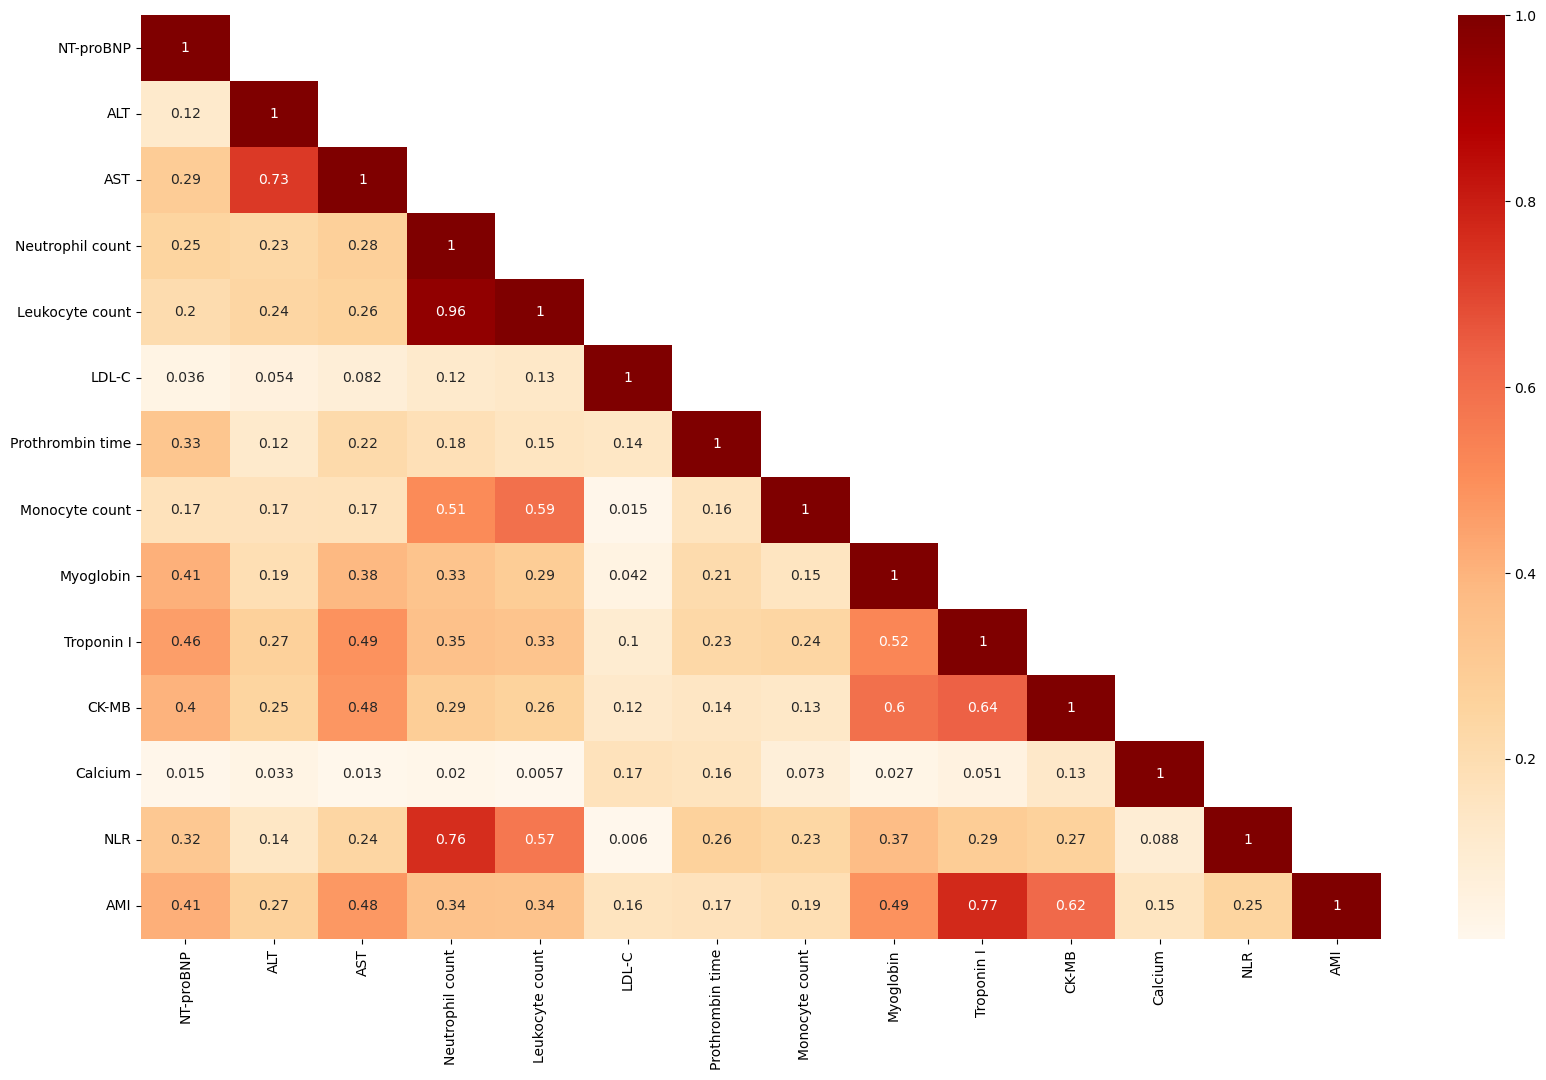

In [7]:
plt.figure(figsize = (20, 12))
sns.heatmap(corr_ratio, annot = True, cmap = 'OrRd', mask = mask)
plt.savefig('picture/Correlation_Analysis.jpg', dpi = 300, facecolor = 'w')

In [8]:
corr_n = corr_ratio['AMI'].sort_values(ascending = False).reset_index()
corr_n.columns = ['target value -- feature（correlation）', 'correlation']

df_n = [col for col in corr_n['target value -- feature（correlation）']]

df = df[df_n]

# Variance inflation factor

In [9]:
del df['Leukocyte count']
del df['Calcium']

In [10]:
X = df.drop(columns = 'AMI')

In [11]:
vif = [variance_inflation_factor(X.values, X.columns.get_loc(i)) for i in X.columns]

In [12]:
vif

[1.5831864207287014,
 1.798563741440132,
 1.7059557386521365,
 6.350145333370972,
 1.3721544206732876,
 4.592697536455852,
 5.806855111263073,
 1.8000373086104353,
 1.7903442472983628,
 4.18883844802752,
 4.680553029242433]

In [13]:
print(list(X.columns))

['Troponin I', 'CK-MB', 'Myoglobin', 'AST', 'NT-proBNP', 'Neutrophil count', 'ALT', 'NLR', 'Monocyte count', 'Prothrombin time', 'LDL-C']


# Split the data

In [14]:
train_data = df[df.columns[1:]]
test_data = df[df.columns[0]]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_data, test_data, test_size=0.3, random_state=2022)

# MinMaxScaler

In [16]:
model_M = MinMaxScaler()
model_M.fit(X_train)
X_train = model_M.transform(X_train)
X_test = model_M.transform(X_test)
train_data = pd.DataFrame(model_M.transform(train_data))

# LogisticRegression

In [17]:
model_LR = LogisticRegression(C=1)
model_LR.fit(X_train, y_train)
predict_LR_train = model_LR.predict(X_train)
predict_LR_test = model_LR.predict(X_test)
print(classification_report(y_train, predict_LR_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_LR_test))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1550
           1       0.92      0.47      0.62       836

    accuracy                           0.80      2386
   macro avg       0.85      0.72      0.74      2386
weighted avg       0.83      0.80      0.78      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       670
           1       0.89      0.45      0.60       353

    accuracy                           0.79      1023
   macro avg       0.83      0.71      0.73      1023
weighted avg       0.81      0.79      0.77      1023



In [18]:
print(accuracy_score(y_train, predict_LR_train))
print(accuracy_score(y_test, predict_LR_test))

0.8000838222967309
0.7908113391984359


In [19]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    model = LogisticRegression(C=1)
    model.fit(train_data_2, train_target)
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'LR train accuracy:', score_train)
    print(k + 1, 'LR test  accuracy:', score_test, '\n')

1 LR train accuracy: 0.8073663624511083
1 LR test  accuracy: 0.7859237536656891 

2 LR train accuracy: 0.8080182529335072
2 LR test  accuracy: 0.7859237536656891 

3 LR train accuracy: 0.8034550195567145
3 LR test  accuracy: 0.8269794721407625 

4 LR train accuracy: 0.8067144719687093
4 LR test  accuracy: 0.7771260997067448 

5 LR train accuracy: 0.8047588005215124
5 LR test  accuracy: 0.8064516129032258 

6 LR train accuracy: 0.8054106910039114
6 LR test  accuracy: 0.8064516129032258 

7 LR train accuracy: 0.8044328552803129
7 LR test  accuracy: 0.8123167155425219 

8 LR train accuracy: 0.8050847457627118
8 LR test  accuracy: 0.8035190615835777 

9 LR train accuracy: 0.8037809647979139
9 LR test  accuracy: 0.8211143695014663 

10 LR train accuracy: 0.8057999348321929
10 LR test  accuracy: 0.8264705882352941 



# GA-LogisticRegression

In [20]:
def func_LR(X):
    model = LogisticRegression(C=X[0])
    model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    output = 2 - accuracy_score(y_test, predict_test) - accuracy_score(y_train, predict_train)
    
    return output

pop = 20
MaxIter = 30
dim = 1
lb = [0.01]
ub = [10]

ga = GA(func=func_LR, n_dim=dim, size_pop=pop, max_iter=MaxIter, lb=lb, ub=ub, precision=[1e-7])
best_x, best_y = ga.run()
model_LR_GA = LogisticRegression(C=best_x[0])
model_LR_GA.fit(X_train, y_train)
predict_LR_GA_train = model_LR_GA.predict(X_train)
predict_LR_GA_test = model_LR_GA.predict(X_test)
print(classification_report(y_train, predict_LR_GA_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_LR_GA_test))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1550
           1       0.95      0.71      0.82       836

    accuracy                           0.89      2386
   macro avg       0.91      0.85      0.87      2386
weighted avg       0.89      0.89      0.88      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       670
           1       0.93      0.71      0.80       353

    accuracy                           0.88      1023
   macro avg       0.90      0.84      0.86      1023
weighted avg       0.89      0.88      0.88      1023



In [21]:
print(accuracy_score(y_train, predict_LR_GA_train))
print(accuracy_score(y_test, predict_LR_GA_test))

0.8868398994132439
0.8807429130009775


In [22]:
best_x

array([9.8053224])

In [23]:
kf = KFold(n_splits = 10, shuffle = True)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    model = LogisticRegression(C=best_x[0])
    model.fit(train_data_2, train_target)
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'GA-LR train accuracy:', score_train)
    print(k + 1, 'GA-LR test  accuracy:', score_test, '\n')

1 GA-LR train accuracy: 0.8914602346805737
1 GA-LR test  accuracy: 0.8680351906158358 

2 GA-LR train accuracy: 0.8878748370273793
2 GA-LR test  accuracy: 0.8885630498533724 

3 GA-LR train accuracy: 0.8895045632333768
3 GA-LR test  accuracy: 0.9002932551319648 

4 GA-LR train accuracy: 0.8901564537157758
4 GA-LR test  accuracy: 0.8826979472140762 

5 GA-LR train accuracy: 0.8927640156453716
5 GA-LR test  accuracy: 0.8651026392961877 

6 GA-LR train accuracy: 0.8872229465449805
6 GA-LR test  accuracy: 0.906158357771261 

7 GA-LR train accuracy: 0.8914602346805737
7 GA-LR test  accuracy: 0.8797653958944281 

8 GA-LR train accuracy: 0.8914602346805737
8 GA-LR test  accuracy: 0.8885630498533724 

9 GA-LR train accuracy: 0.8875488917861799
9 GA-LR test  accuracy: 0.8944281524926686 

10 GA-LR train accuracy: 0.888237210817856
10 GA-LR test  accuracy: 0.9176470588235294 



# GS-LogisticRegression

In [24]:
model = LogisticRegression()
parameters = {
    'C':[i for i in range(1, 11)]
}

model_GSCV = GridSearchCV(model, parameters, scoring = 'accuracy', n_jobs = -1, cv = 5)
model_GSCV.fit(X_train, y_train)

score_ACC = accuracy_score(y_test, model_GSCV.predict(X_test))

print('最优参数：', model_GSCV.best_params_)

model_LR_GS = LogisticRegression(C=model_GSCV.best_params_['C'])
model_LR_GS.fit(X_train, y_train)
predict_LR_GS_train = model_LR_GS.predict(X_train)
predict_LR_GS_test = model_LR_GS.predict(X_test)
print(classification_report(y_train, predict_LR_GS_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_LR_GS_test))

最优参数： {'C': 10}
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1550
           1       0.95      0.72      0.82       836

    accuracy                           0.89      2386
   macro avg       0.91      0.85      0.87      2386
weighted avg       0.90      0.89      0.88      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       670
           1       0.93      0.71      0.80       353

    accuracy                           0.88      1023
   macro avg       0.90      0.84      0.86      1023
weighted avg       0.89      0.88      0.88      1023



In [25]:
print(accuracy_score(y_train, predict_LR_GS_train))
print(accuracy_score(y_test, predict_LR_GS_test))

0.8880972338642079
0.8807429130009775


In [26]:
kf = KFold(n_splits = 10, shuffle = True)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    model = LogisticRegression(C=model_GSCV.best_params_['C'])
    model.fit(train_data_2, train_target)
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'GS-LR train accuracy:', score_train)
    print(k + 1, 'GS-LR test  accuracy:', score_test, '\n')

1 GS-LR train accuracy: 0.8908083441981747
1 GS-LR test  accuracy: 0.873900293255132 

2 GS-LR train accuracy: 0.8904823989569752
2 GS-LR test  accuracy: 0.8709677419354839 

3 GS-LR train accuracy: 0.8934159061277706
3 GS-LR test  accuracy: 0.8914956011730205 

4 GS-LR train accuracy: 0.8888526727509778
4 GS-LR test  accuracy: 0.9032258064516129 

5 GS-LR train accuracy: 0.8940677966101694
5 GS-LR test  accuracy: 0.873900293255132 

6 GS-LR train accuracy: 0.8895045632333768
6 GS-LR test  accuracy: 0.8914956011730205 

7 GS-LR train accuracy: 0.8895045632333768
7 GS-LR test  accuracy: 0.9120234604105572 

8 GS-LR train accuracy: 0.8891786179921773
8 GS-LR test  accuracy: 0.8797653958944281 

9 GS-LR train accuracy: 0.8891786179921773
9 GS-LR test  accuracy: 0.9002932551319648 

10 GS-LR train accuracy: 0.8875855327468231
10 GS-LR test  accuracy: 0.9058823529411765 



# SVM

In [27]:
model_SVC = SVC(kernel='linear', probability=True, C=1, gamma=1)
model_SVC.fit(X_train, y_train)
predict_SVC_train = model_SVC.predict(X_train)
predict_SVC_test = model_SVC.predict(X_test)
print(classification_report(y_train, predict_SVC_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_SVC_test))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1550
           1       0.95      0.53      0.68       836

    accuracy                           0.82      2386
   macro avg       0.87      0.76      0.78      2386
weighted avg       0.85      0.82      0.81      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       670
           1       0.91      0.49      0.64       353

    accuracy                           0.81      1023
   macro avg       0.84      0.73      0.75      1023
weighted avg       0.83      0.81      0.79      1023



In [28]:
print(accuracy_score(y_train, predict_SVC_train))
print(accuracy_score(y_test, predict_SVC_test))

0.8248113998323554
0.8064516129032258


In [29]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    model = SVC(kernel='linear', probability=True, C=1, gamma=1)
    model.fit(train_data_2, train_target)
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'SVC train accuracy:', score_train)
    print(k + 1, 'SVC test  accuracy:', score_test, '\n')

1 SVC train accuracy: 0.840612777053455
1 SVC test  accuracy: 0.8269794721407625 

2 SVC train accuracy: 0.8402868318122555
2 SVC test  accuracy: 0.8181818181818182 

3 SVC train accuracy: 0.8409387222946545
3 SVC test  accuracy: 0.8475073313782991 

4 SVC train accuracy: 0.8383311603650587
4 SVC test  accuracy: 0.8240469208211144 

5 SVC train accuracy: 0.839960886571056
5 SVC test  accuracy: 0.8299120234604106 

6 SVC train accuracy: 0.8389830508474576
6 SVC test  accuracy: 0.8504398826979472 

7 SVC train accuracy: 0.839960886571056
7 SVC test  accuracy: 0.8504398826979472 

8 SVC train accuracy: 0.8383311603650587
8 SVC test  accuracy: 0.8299120234604106 

9 SVC train accuracy: 0.8350717079530638
9 SVC test  accuracy: 0.8533724340175953 

10 SVC train accuracy: 0.8396871945259042
10 SVC test  accuracy: 0.8647058823529412 



# GA-SVM

In [30]:
def func_SVC(X):
    model = SVC(C=X[0], gamma=X[1], kernel='linear', probability=True)
    model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    output = 2 - accuracy_score(y_test, predict_test) - accuracy_score(y_train, predict_train)
    
    return output

pop = 20
MaxIter = 30
dim = 2
lb = [0.01, 0.01]
ub = [10, 10]

ga = GA(func=func_SVC, n_dim=dim, size_pop=pop, max_iter=MaxIter, lb=lb, ub=ub, precision=[1e-7, 1e-7])
best_x, best_y = ga.run()
model_SVC_GA = SVC(C=best_x[0], gamma=best_x[1], kernel='linear', probability=True)
model_SVC_GA.fit(X_train, y_train)
predict_SVC_GA_train = model_SVC_GA.predict(X_train)
predict_SVC_GA_test = model_SVC_GA.predict(X_test)
print(classification_report(y_train, predict_SVC_GA_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_SVC_GA_test))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1550
           1       0.97      0.80      0.87       836

    accuracy                           0.92      2386
   macro avg       0.93      0.89      0.91      2386
weighted avg       0.92      0.92      0.92      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       670
           1       0.94      0.78      0.85       353

    accuracy                           0.91      1023
   macro avg       0.92      0.87      0.89      1023
weighted avg       0.91      0.91      0.90      1023



In [31]:
print(accuracy_score(y_train, predict_SVC_GA_train))
print(accuracy_score(y_test, predict_SVC_GA_test))

0.9186923721709975
0.9051808406647116


In [32]:
print(best_x)

[9.32215816 6.46479524]


In [33]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    model = SVC(C=best_x[0], gamma=best_x[1], kernel='linear', probability=True)
    model.fit(train_data_2, train_target)
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'GA-SVC train accuracy:', score_train)
    print(k + 1, 'GA-SVC test  accuracy:', score_test, '\n')

1 GA-SVC train accuracy: 0.9172099087353325
1 GA-SVC test  accuracy: 0.8973607038123167 

2 GA-SVC train accuracy: 0.915580182529335
2 GA-SVC test  accuracy: 0.9120234604105572 

3 GA-SVC train accuracy: 0.9172099087353325
3 GA-SVC test  accuracy: 0.906158357771261 

4 GA-SVC train accuracy: 0.9149282920469362
4 GA-SVC test  accuracy: 0.9149560117302052 

5 GA-SVC train accuracy: 0.9165580182529335
5 GA-SVC test  accuracy: 0.9237536656891495 

6 GA-SVC train accuracy: 0.9139504563233377
6 GA-SVC test  accuracy: 0.9266862170087976 

7 GA-SVC train accuracy: 0.9181877444589309
7 GA-SVC test  accuracy: 0.9090909090909091 

8 GA-SVC train accuracy: 0.9175358539765319
8 GA-SVC test  accuracy: 0.906158357771261 

9 GA-SVC train accuracy: 0.9139504563233377
9 GA-SVC test  accuracy: 0.9237536656891495 

10 GA-SVC train accuracy: 0.9149560117302052
10 GA-SVC test  accuracy: 0.9382352941176471 



# GS-SVM

In [34]:
model = SVC(kernel='linear', probability=True)
parameters = {
    'C':[1],
    'gamma': [i for i in range(5, 11)]
}

model_GSCV = GridSearchCV(model, parameters, scoring = 'accuracy', n_jobs = -1, cv = 5)
model_GSCV.fit(X_train, y_train)

score_ACC = accuracy_score(y_test, model_GSCV.predict(X_test))

print('最优参数：', model_GSCV.best_params_)

model_SVC_GS = SVC(C=model_GSCV.best_params_['C'], gamma=model_GSCV.best_params_['gamma'], kernel='linear', probability=True)
model_SVC_GS.fit(X_train, y_train)
predict_SVC_GS_train = model_SVC_GS.predict(X_train)
predict_SVC_GS_test = model_SVC_GS.predict(X_test)
print(classification_report(y_train, predict_SVC_GS_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_SVC_GS_test))

最优参数： {'C': 1, 'gamma': 5}
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1550
           1       0.95      0.53      0.68       836

    accuracy                           0.82      2386
   macro avg       0.87      0.76      0.78      2386
weighted avg       0.85      0.82      0.81      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       670
           1       0.91      0.49      0.64       353

    accuracy                           0.81      1023
   macro avg       0.84      0.73      0.75      1023
weighted avg       0.83      0.81      0.79      1023



In [35]:
print(accuracy_score(y_train, predict_SVC_GS_train))
print(accuracy_score(y_test, predict_SVC_GS_test))

0.8248113998323554
0.8064516129032258


In [36]:
kf = KFold(n_splits = 10, shuffle = True)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    model = SVC(C=model_GSCV.best_params_['C'], gamma=model_GSCV.best_params_['gamma'], kernel='linear', probability=True)
    model.fit(train_data_2, train_target)
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'GS-SVC train accuracy:', score_train)
    print(k + 1, 'GS-SVC test  accuracy:', score_test, '\n')

1 GS-SVC train accuracy: 0.8419165580182529
1 GS-SVC test  accuracy: 0.844574780058651 

2 GS-SVC train accuracy: 0.839960886571056
2 GS-SVC test  accuracy: 0.844574780058651 

3 GS-SVC train accuracy: 0.8419165580182529
3 GS-SVC test  accuracy: 0.8240469208211144 

4 GS-SVC train accuracy: 0.8376792698826597
4 GS-SVC test  accuracy: 0.8563049853372434 

5 GS-SVC train accuracy: 0.8367014341590613
5 GS-SVC test  accuracy: 0.8592375366568915 

6 GS-SVC train accuracy: 0.8435462842242504
6 GS-SVC test  accuracy: 0.8211143695014663 

7 GS-SVC train accuracy: 0.8347457627118644
7 GS-SVC test  accuracy: 0.841642228739003 

8 GS-SVC train accuracy: 0.8415906127770535
8 GS-SVC test  accuracy: 0.841642228739003 

9 GS-SVC train accuracy: 0.8425684485006519
9 GS-SVC test  accuracy: 0.8328445747800587 

10 GS-SVC train accuracy: 0.8393613554903877
10 GS-SVC test  accuracy: 0.8352941176470589 



# RF

In [263]:
model_RF = RandomForestClassifier(n_estimators=5, max_depth=3, max_features=6, min_samples_leaf=1, min_samples_split=0.1)
model_RF.fit(X_train, y_train)
predict_RF_train = model_RF.predict(X_train)
predict_RF_test = model_RF.predict(X_test)
print(classification_report(y_train, predict_RF_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_RF_test))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1550
           1       0.93      0.89      0.91       836

    accuracy                           0.94      2386
   macro avg       0.94      0.93      0.93      2386
weighted avg       0.94      0.94      0.94      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       670
           1       0.89      0.87      0.88       353

    accuracy                           0.92      1023
   macro avg       0.91      0.90      0.91      1023
weighted avg       0.92      0.92      0.92      1023



In [264]:
print(accuracy_score(y_train, predict_RF_train))
print(accuracy_score(y_test, predict_RF_test))

0.9371332774518022
0.9159335288367546


In [265]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    model = RandomForestClassifier(n_estimators=10, max_depth=6, max_features=6, min_samples_leaf=1, min_samples_split=0.1)
    model.fit(train_data_2, train_target)
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'RF train accuracy:', score_train)
    print(k + 1, 'RF test  accuracy:', score_test, '\n')

1 RF train accuracy: 0.9423076923076923
1 RF test  accuracy: 0.9266862170087976 

2 RF train accuracy: 0.9387222946544981
2 RF test  accuracy: 0.9149560117302052 

3 RF train accuracy: 0.9364406779661016
3 RF test  accuracy: 0.9325513196480938 

4 RF train accuracy: 0.9338331160365059
4 RF test  accuracy: 0.9354838709677419 

5 RF train accuracy: 0.93122555410691
5 RF test  accuracy: 0.9442815249266863 

6 RF train accuracy: 0.9364406779661016
6 RF test  accuracy: 0.9501466275659824 

7 RF train accuracy: 0.9374185136897001
7 RF test  accuracy: 0.9237536656891495 

8 RF train accuracy: 0.9367666232073012
8 RF test  accuracy: 0.9384164222873901 

9 RF train accuracy: 0.9370925684485006
9 RF test  accuracy: 0.9266862170087976 

10 RF train accuracy: 0.9380905832518736
10 RF test  accuracy: 0.9294117647058824 



# GA-RF

In [40]:
def func_RF(X):
    model = RandomForestClassifier(n_estimators=int(X[0]), max_depth=int(X[1]), max_features=int(X[2]), min_samples_leaf=int(X[3]), min_samples_split=int(X[4]))
    model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    output = 2 - accuracy_score(y_test, predict_test) - accuracy_score(y_train, predict_train)
    
    return output

pop = 20
MaxIter = 30
dim = 5
lb = [10, 6, 3, 1, 2]
ub = [30, 11, X_train.shape[1], 6, 6]

ga = GA(func=func_RF, n_dim=dim, size_pop=pop, max_iter=MaxIter, lb=lb, ub=ub, precision=[1e-7, 1e-7, 1e-7, 1e-7, 1e-7])
best_x, best_y = ga.run()
model_RF_GA = RandomForestClassifier(n_estimators=int(best_x[0]), max_depth=int(best_x[1]), max_features=int(best_x[2]), min_samples_leaf=int(best_x[3]), min_samples_split=int(best_x[4]))
model_RF_GA.fit(X_train, y_train)
predict_RF_GA_train = model_RF_GA.predict(X_train)
predict_RF_GA_test = model_RF_GA.predict(X_test)
print(classification_report(y_train, predict_RF_GA_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_RF_GA_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1550
           1       1.00      0.98      0.99       836

    accuracy                           0.99      2386
   macro avg       0.99      0.99      0.99      2386
weighted avg       0.99      0.99      0.99      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       670
           1       0.91      0.87      0.89       353

    accuracy                           0.93      1023
   macro avg       0.92      0.91      0.92      1023
weighted avg       0.93      0.93      0.93      1023



In [41]:
print(accuracy_score(y_train, predict_RF_GA_train))
print(accuracy_score(y_test, predict_RF_GA_test))

0.991617770326907
0.9257086999022482


In [42]:
print(best_x)

[28.93322087 10.42682191  5.4195561   1.9631321   3.61962822]


In [43]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    model = RandomForestClassifier(n_estimators=int(best_x[0]), max_depth=int(best_x[1]), max_features=int(best_x[2]), min_samples_leaf=int(best_x[3]), min_samples_split=int(best_x[4]))
    model.fit(train_data_2, train_target)
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'GA-RF train accuracy:', score_train)
    print(k + 1, 'GA-RF test  accuracy:', score_test, '\n')

1 GA-RF train accuracy: 0.9879400260756193
1 GA-RF test  accuracy: 0.9237536656891495 

2 GA-RF train accuracy: 0.9869621903520208
2 GA-RF test  accuracy: 0.9266862170087976 

3 GA-RF train accuracy: 0.9895697522816167
3 GA-RF test  accuracy: 0.9354838709677419 

4 GA-RF train accuracy: 0.9895697522816167
4 GA-RF test  accuracy: 0.9472140762463344 

5 GA-RF train accuracy: 0.9872881355932204
5 GA-RF test  accuracy: 0.9384164222873901 

6 GA-RF train accuracy: 0.9879400260756193
6 GA-RF test  accuracy: 0.9589442815249267 

7 GA-RF train accuracy: 0.9908735332464146
7 GA-RF test  accuracy: 0.9413489736070382 

8 GA-RF train accuracy: 0.9879400260756193
8 GA-RF test  accuracy: 0.9354838709677419 

9 GA-RF train accuracy: 0.9898956975228161
9 GA-RF test  accuracy: 0.9413489736070382 

10 GA-RF train accuracy: 0.9905506679700228
10 GA-RF test  accuracy: 0.9352941176470588 



# GS-RF

In [44]:
model = RandomForestClassifier()
parameters = {
    'n_estimators':[10],
    'max_depth': [3],
    'max_features': [3],
    'min_samples_leaf': [1],
    'min_samples_split': [i / 10 for i in range(2, 6)]
}

model_GSCV = GridSearchCV(model, parameters, scoring = 'accuracy', n_jobs = 15, cv = 5)
model_GSCV.fit(X_train, y_train)

score_ACC = accuracy_score(y_test, model_GSCV.predict(X_test))

print('最优参数：', model_GSCV.best_params_)

model_RF_GS = RandomForestClassifier(n_estimators=model_GSCV.best_params_['n_estimators'], max_depth=model_GSCV.best_params_['max_depth'], max_features=model_GSCV.best_params_['max_features'], min_samples_leaf=model_GSCV.best_params_['min_samples_leaf'], min_samples_split=model_GSCV.best_params_['min_samples_split'])
model_RF_GS.fit(X_train, y_train)
predict_RF_GS_train = model_RF_GS.predict(X_train)
predict_RF_GS_test = model_RF_GS.predict(X_test)
print(classification_report(y_train, predict_RF_GS_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_RF_GS_test))

最优参数： {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 0.2, 'n_estimators': 10}
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1550
           1       0.94      0.89      0.91       836

    accuracy                           0.94      2386
   macro avg       0.94      0.93      0.93      2386
weighted avg       0.94      0.94      0.94      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       670
           1       0.91      0.85      0.88       353

    accuracy                           0.92      1023
   macro avg       0.92      0.90      0.91      1023
weighted avg       0.92      0.92      0.92      1023



In [45]:
print(accuracy_score(y_train, predict_RF_GS_train))
print(accuracy_score(y_test, predict_RF_GS_test))

0.9388097233864208
0.9198435972629521


In [46]:
kf = KFold(n_splits = 10, shuffle = True)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    model = RandomForestClassifier(n_estimators=model_GSCV.best_params_['n_estimators'], max_depth=model_GSCV.best_params_['max_depth'], max_features=model_GSCV.best_params_['max_features'], min_samples_leaf=model_GSCV.best_params_['min_samples_leaf'], min_samples_split=model_GSCV.best_params_['min_samples_split'])
    model.fit(train_data_2, train_target)
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'GS-RF train accuracy:', score_train)
    print(k + 1, 'GS-RF test  accuracy:', score_test, '\n')

1 GS-RF train accuracy: 0.9080834419817471
1 GS-RF test  accuracy: 0.9149560117302052 

2 GS-RF train accuracy: 0.9308996088657105
2 GS-RF test  accuracy: 0.9149560117302052 

3 GS-RF train accuracy: 0.9253585397653195
3 GS-RF test  accuracy: 0.9237536656891495 

4 GS-RF train accuracy: 0.9263363754889179
4 GS-RF test  accuracy: 0.9325513196480938 

5 GS-RF train accuracy: 0.9142764015645372
5 GS-RF test  accuracy: 0.9237536656891495 

6 GS-RF train accuracy: 0.9354628422425033
6 GS-RF test  accuracy: 0.9413489736070382 

7 GS-RF train accuracy: 0.9201434159061278
7 GS-RF test  accuracy: 0.9208211143695014 

8 GS-RF train accuracy: 0.9322033898305084
8 GS-RF test  accuracy: 0.9413489736070382 

9 GS-RF train accuracy: 0.9331812255541069
9 GS-RF test  accuracy: 0.9325513196480938 

10 GS-RF train accuracy: 0.9035516454871294
10 GS-RF test  accuracy: 0.9058823529411765 



# XGBoost

In [47]:
model_XGB = XGBClassifier(n_estimators=4, max_depth=3, gamma=0.1, alpha=0.1, reg_lambda=6)
model_XGB.fit(X_train, y_train)
predict_XGB_train = model_XGB.predict(X_train)
predict_XGB_test = model_XGB.predict(X_test)
print(classification_report(y_train, predict_XGB_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_XGB_test))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1550
           1       0.94      0.89      0.91       836

    accuracy                           0.94      2386
   macro avg       0.94      0.93      0.93      2386
weighted avg       0.94      0.94      0.94      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       670
           1       0.91      0.87      0.89       353

    accuracy                           0.93      1023
   macro avg       0.92      0.91      0.92      1023
weighted avg       0.93      0.93      0.93      1023



In [48]:
print(accuracy_score(y_train, predict_XGB_train))
print(accuracy_score(y_test, predict_XGB_test))

0.940905280804694
0.9257086999022482


In [49]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    model = XGBClassifier(n_estimators=10, max_depth=6, gamma=0.1, alpha=0.1, reg_lambda=6)
    model.fit(train_data_2, train_target)
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'XGBoost train accuracy:', score_train)
    print(k + 1, 'XGBoost test  accuracy:', score_test, '\n')

1 XGBoost train accuracy: 0.9641460234680573
1 XGBoost test  accuracy: 0.9178885630498533 

2 XGBoost train accuracy: 0.96251629726206
2 XGBoost test  accuracy: 0.9296187683284457 

3 XGBoost train accuracy: 0.9631681877444589
3 XGBoost test  accuracy: 0.9354838709677419 

4 XGBoost train accuracy: 0.9647979139504563
4 XGBoost test  accuracy: 0.9472140762463344 

5 XGBoost train accuracy: 0.9644719687092569
5 XGBoost test  accuracy: 0.9442815249266863 

6 XGBoost train accuracy: 0.9641460234680573
6 XGBoost test  accuracy: 0.9648093841642229 

7 XGBoost train accuracy: 0.961864406779661
7 XGBoost test  accuracy: 0.9501466275659824 

8 XGBoost train accuracy: 0.9638200782268579
8 XGBoost test  accuracy: 0.9413489736070382 

9 XGBoost train accuracy: 0.9634941329856584
9 XGBoost test  accuracy: 0.9442815249266863 

10 XGBoost train accuracy: 0.9661127403062887
10 XGBoost test  accuracy: 0.9323529411764706 



# GA-XGBoost

In [362]:
def func_XGB(X):
    model = XGBClassifier(n_estimators=int(X[0]), max_depth=int(X[1]), gamma=X[2], alpha=X[3], reg_lambda=X[4])
    model.fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    output = 2 - accuracy_score(y_test, predict_test) - accuracy_score(y_train, predict_train)
    
    return output

pop = 20
MaxIter = 30
dim = 5
lb = [10, 6, 0.1, 0, 1]
ub = [30, 11, 1, 1, 11]

ga = GA(func=func_XGB, n_dim=dim, size_pop=pop, max_iter=MaxIter, lb=lb, ub=ub, precision=[1e-7, 1e-7, 1e-7, 1e-7, 1e-7])
best_x, best_y = ga.run()
model_XGB_GA = XGBClassifier(n_estimators=int(best_x[0]), max_depth=int(best_x[1]), gamma=best_x[2], alpha=int(best_x[3]), reg_lambda=best_x[4])
model_XGB_GA.fit(X_train, y_train)
predict_XGB_GA_train = model_XGB_GA.predict(X_train)
predict_XGB_GA_test = model_XGB_GA.predict(X_test)
print(classification_report(y_train, predict_XGB_GA_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_XGB_GA_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1550
           1       1.00      1.00      1.00       836

    accuracy                           1.00      2386
   macro avg       1.00      1.00      1.00      2386
weighted avg       1.00      1.00      1.00      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       670
           1       0.91      0.88      0.89       353

    accuracy                           0.93      1023
   macro avg       0.92      0.92      0.92      1023
weighted avg       0.93      0.93      0.93      1023



In [363]:
print(accuracy_score(y_train, predict_XGB_GA_train))
print(accuracy_score(y_test, predict_XGB_GA_test))

0.9995808885163453
0.9286412512218963


In [364]:
print(best_x)

[28.69  8.01  0.1   0.33  1.33]


In [365]:
kf = KFold(n_splits=10, shuffle=True, random_state=2022)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    model = XGBClassifier(n_estimators=int(best_x[0]), max_depth=int(best_x[1]), gamma=best_x[2], alpha=int(best_x[3]), reg_lambda=best_x[4])
    model.fit(train_data_2, train_target)
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'GA-XGBoost train accuracy:', score_train)
    print(k + 1, 'GA-XGBoost test  accuracy:', score_test, '\n')

1 GA-XGBoost train accuracy: 0.9996740547588006
1 GA-XGBoost test  accuracy: 0.9266862170087976 

2 GA-XGBoost train accuracy: 1.0
2 GA-XGBoost test  accuracy: 0.9442815249266863 

3 GA-XGBoost train accuracy: 0.9996740547588006
3 GA-XGBoost test  accuracy: 0.9296187683284457 

4 GA-XGBoost train accuracy: 0.9990221642764016
4 GA-XGBoost test  accuracy: 0.9472140762463344 

5 GA-XGBoost train accuracy: 0.9996740547588006
5 GA-XGBoost test  accuracy: 0.9325513196480938 

6 GA-XGBoost train accuracy: 0.999348109517601
6 GA-XGBoost test  accuracy: 0.9765395894428153 

7 GA-XGBoost train accuracy: 0.999348109517601
7 GA-XGBoost test  accuracy: 0.9413489736070382 

8 GA-XGBoost train accuracy: 0.9996740547588006
8 GA-XGBoost test  accuracy: 0.9296187683284457 

9 GA-XGBoost train accuracy: 1.0
9 GA-XGBoost test  accuracy: 0.9442815249266863 

10 GA-XGBoost train accuracy: 0.9996741609644836
10 GA-XGBoost test  accuracy: 0.9352941176470588 



# GS-XGBoost

In [54]:
model = XGBClassifier()
parameters = {
    'n_estimators':[5],
    'max_depth': [3],
    'gamma': [0.1],
    'alpha': [0.1],
    'reg_lambda': [i / 10 for i in range(1, 12)]
}

model_GSCV = GridSearchCV(model, parameters, scoring = 'accuracy', n_jobs = 15, cv = 5)
model_GSCV.fit(X_train, y_train)

score_ACC = accuracy_score(y_test, model_GSCV.predict(X_test))

print('最优参数：', model_GSCV.best_params_)

model_XGB_GS = XGBClassifier(n_estimators=model_GSCV.best_params_['n_estimators'], max_depth=model_GSCV.best_params_['max_depth'], max_gamma=model_GSCV.best_params_['gamma'], min_alpha=model_GSCV.best_params_['alpha'], reg_lambda=model_GSCV.best_params_['reg_lambda'])
model_XGB_GS.fit(X_train, y_train)
predict_XGB_GS_train = model_XGB_GS.predict(X_train)
predict_XGB_GS_test = model_XGB_GS.predict(X_test)
print(classification_report(y_train, predict_XGB_GS_train))
print('-----------------------------------------------------')
print(classification_report(y_test, predict_XGB_GS_test))

最优参数： {'alpha': 0.1, 'gamma': 0.1, 'max_depth': 3, 'n_estimators': 5, 'reg_lambda': 0.1}
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1550
           1       0.94      0.91      0.93       836

    accuracy                           0.95      2386
   macro avg       0.95      0.94      0.94      2386
weighted avg       0.95      0.95      0.95      2386

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       670
           1       0.91      0.87      0.89       353

    accuracy                           0.93      1023
   macro avg       0.92      0.91      0.92      1023
weighted avg       0.93      0.93      0.93      1023



In [55]:
print(accuracy_score(y_train, predict_XGB_GS_train))
print(accuracy_score(y_test, predict_XGB_GS_test))

0.9501257334450964
0.9266862170087976


In [56]:
kf = KFold(n_splits = 10, shuffle = True)
for k, (train_index, test_index) in enumerate(kf.split(train_data)):
    model = XGBClassifier(n_estimators=model_GSCV.best_params_['n_estimators'], max_depth=model_GSCV.best_params_['max_depth'], max_gamma=model_GSCV.best_params_['gamma'], min_alpha=model_GSCV.best_params_['alpha'], reg_lambda=model_GSCV.best_params_['reg_lambda'])
    model.fit(train_data_2, train_target)
    train_data_2,test_data_2,train_target,test_target = train_data.values[train_index], train_data.values[test_index], test_data[train_index], test_data[test_index]
    score_train = accuracy_score(train_target, model.predict(train_data_2))
    score_test = accuracy_score(test_target, model.predict(test_data_2))
    print(k + 1, 'RS-XGB train accuracy:', score_train)
    print(k + 1, 'RS-XGB test  accuracy:', score_test, '\n')

1 RS-XGB train accuracy: 0.9458930899608866
1 RS-XGB test  accuracy: 0.9296187683284457 

2 RS-XGB train accuracy: 0.9458930899608866
2 RS-XGB test  accuracy: 0.9149560117302052 

3 RS-XGB train accuracy: 0.9410039113428944
3 RS-XGB test  accuracy: 0.9618768328445748 

4 RS-XGB train accuracy: 0.940677966101695
4 RS-XGB test  accuracy: 0.9384164222873901 

5 RS-XGB train accuracy: 0.9403520208604954
5 RS-XGB test  accuracy: 0.9442815249266863 

6 RS-XGB train accuracy: 0.940677966101695
6 RS-XGB test  accuracy: 0.9501466275659824 

7 RS-XGB train accuracy: 0.9423076923076923
7 RS-XGB test  accuracy: 0.9237536656891495 

8 RS-XGB train accuracy: 0.9403520208604954
8 RS-XGB test  accuracy: 0.9384164222873901 

9 RS-XGB train accuracy: 0.9410039113428944
9 RS-XGB test  accuracy: 0.9442815249266863 

10 RS-XGB train accuracy: 0.9384164222873901
10 RS-XGB test  accuracy: 0.9735294117647059 



# Rank of feature importance

In [57]:
map_vir = cm.get_cmap(name='inferno')

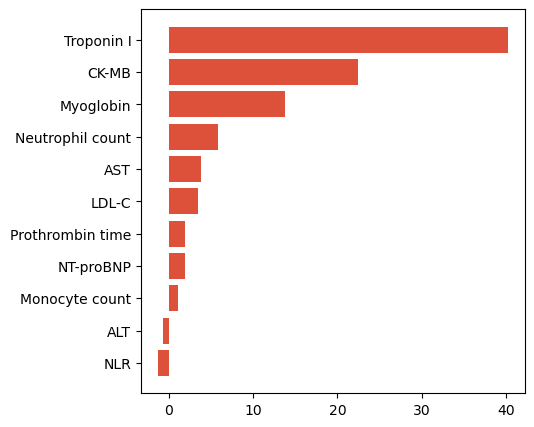

In [366]:
features = df.drop(columns = 'AMI').columns
importances = model_LR_GA.coef_[0]
F = pd.DataFrame()
F['Characteristic'] = features
F['Characteristic_importance'] = importances
F = F.sort_values('Characteristic_importance', ascending = True)
plt.barh(F['Characteristic'], F['Characteristic_importance'], color = map_vir(0.6))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
plt.savefig('picture/Characteristic_importance_LR_GA.jpg', dpi = 300, facecolor = 'w')

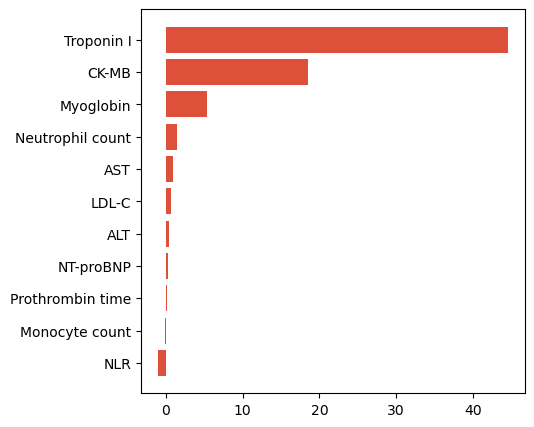

In [367]:
features = df.drop(columns = 'AMI').columns
importances = model_SVC_GA.coef_[0]
F = pd.DataFrame()
F['Characteristic'] = features
F['Characteristic_importance'] = importances
F = F.sort_values('Characteristic_importance', ascending = True)
plt.barh(F['Characteristic'], F['Characteristic_importance'], color = map_vir(0.6))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
plt.savefig('picture/Characteristic_importance_SVC_GA.jpg', dpi = 300, facecolor = 'w')

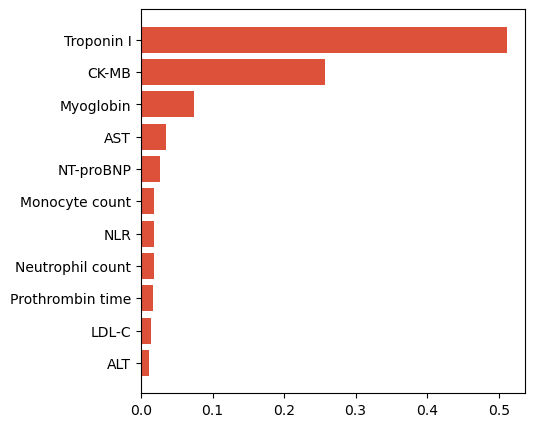

In [368]:
features = df.drop(columns = 'AMI').columns
importances = model_RF_GA.feature_importances_
F = pd.DataFrame()
F['Characteristic'] = features
F['Characteristic_importance'] = importances
F = F.sort_values('Characteristic_importance', ascending = True)
plt.barh(F['Characteristic'], F['Characteristic_importance'], color = map_vir(0.6))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
plt.savefig('picture/Characteristic_importance_RF_GA.jpg', dpi = 300, facecolor = 'w')

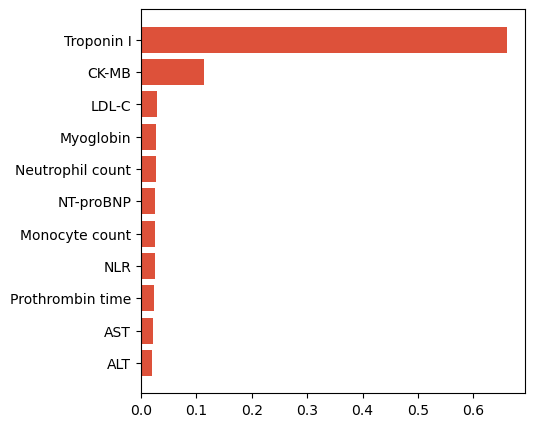

In [369]:
features = df.drop(columns = 'AMI').columns
importances = model_XGB_GA.feature_importances_
F = pd.DataFrame()
F['Characteristic'] = features
F['Characteristic_importance'] = importances
F = F.sort_values('Characteristic_importance', ascending = True)
plt.barh(F['Characteristic'], F['Characteristic_importance'], color = map_vir(0.6))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
plt.savefig('picture/Characteristic_importance_XGB_GA.jpg', dpi = 300, facecolor = 'w')

# ROC curve

In [370]:
P1_1 = model_LR.predict_proba(X_test)
P2_1 = model_SVC.predict_proba(X_test)
P3_1 = model_RF.predict_proba(X_test)
P4_1 = model_XGB.predict_proba(X_test)
P1_2 = model_LR_GA.predict_proba(X_test)
P2_2 = model_SVC_GA.predict_proba(X_test)
P3_2 = model_RF_GA.predict_proba(X_test)
P4_2 = model_XGB_GA.predict_proba(X_test)
P1_3 = model_LR_GS.predict_proba(X_test)
P2_3 = model_SVC_GS.predict_proba(X_test)
P3_3 = model_RF_GS.predict_proba(X_test)
P4_3 = model_XGB_GS.predict_proba(X_test)

In [371]:
fpr1_1, tpr1_1, thres1_1 = roc_curve(y_test, P1_1[:, 1])
fpr2_1, tpr2_1, thres2_1 = roc_curve(y_test, P2_1[:, 1])
fpr3_1, tpr3_1, thres3_1 = roc_curve(y_test, P3_1[:, 1])
fpr4_1, tpr4_1, thres4_1 = roc_curve(y_test, P4_1[:, 1])
fpr1_2, tpr1_2, thres1_2 = roc_curve(y_test, P1_2[:, 1])
fpr2_2, tpr2_2, thres2_2 = roc_curve(y_test, P2_2[:, 1])
fpr3_2, tpr3_2, thres3_2 = roc_curve(y_test, P3_2[:, 1])
fpr4_2, tpr4_2, thres4_2 = roc_curve(y_test, P4_2[:, 1])
fpr1_3, tpr1_3, thres1_3 = roc_curve(y_test, P1_3[:, 1])
fpr2_3, tpr2_3, thres2_3 = roc_curve(y_test, P2_3[:, 1])
fpr3_3, tpr3_3, thres3_3 = roc_curve(y_test, P3_3[:, 1])
fpr4_3, tpr4_3, thres4_3 = roc_curve(y_test, P4_3[:, 1])

In [372]:
auc1_1 = roc_auc_score(y_test, P1_1[:, 1])
auc2_1 = roc_auc_score(y_test, P2_1[:, 1])
auc3_1 = roc_auc_score(y_test, P3_1[:, 1])
auc4_1 = roc_auc_score(y_test, P4_1[:, 1])
auc1_2 = roc_auc_score(y_test, P1_2[:, 1])
auc2_2 = roc_auc_score(y_test, P2_2[:, 1])
auc3_2 = roc_auc_score(y_test, P3_2[:, 1])
auc4_2 = roc_auc_score(y_test, P4_2[:, 1])
auc1_3 = roc_auc_score(y_test, P1_3[:, 1])
auc2_3 = roc_auc_score(y_test, P2_3[:, 1])
auc3_3 = roc_auc_score(y_test, P3_3[:, 1])
auc4_3 = roc_auc_score(y_test, P4_3[:, 1])

In [373]:
print(auc1_1)
print(auc2_1)
print(auc3_1)
print(auc4_1)
print(auc1_2)
print(auc2_2)
print(auc3_2)
print(auc4_2)
print(auc1_3)
print(auc2_3)
print(auc3_3)
print(auc4_3)

0.9159401293814216
0.9450551773709358
0.959449917551055
0.9460572491649403
0.9453130945837385
0.9552196524459854
0.9739524755824278
0.9763012134793454
0.94549067692698
0.9450551773709358
0.9514587121051964
0.9568707454230265


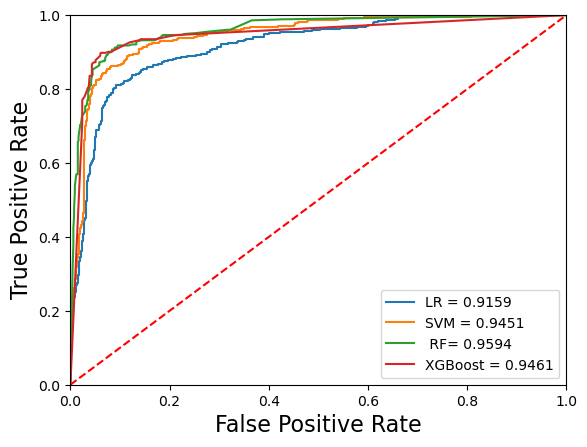

In [374]:
plt.plot(fpr1_1, tpr1_1, label = 'LR = %0.4f' % auc1_1)
plt.plot(fpr2_1, tpr2_1, label = 'SVM = %0.4f' % auc2_1)
plt.plot(fpr3_1, tpr3_1, label = ' RF= %0.4f' % auc3_1)
plt.plot(fpr4_1, tpr4_1, label = 'XGBoost = %0.4f' % auc4_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.savefig('picture/ROC.jpg', dpi = 300, facecolor = 'w')
plt.show()

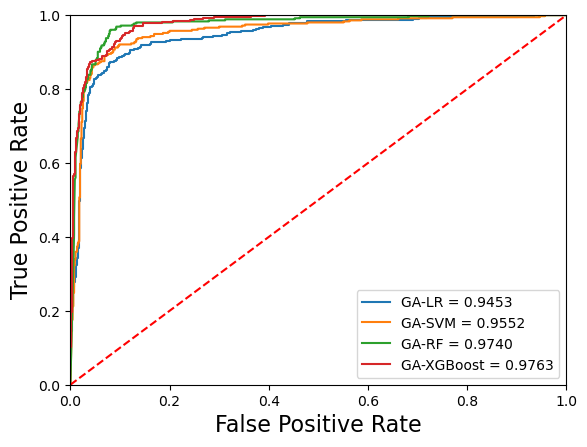

In [375]:
plt.plot(fpr1_2, tpr1_2, label = 'GA-LR = %0.4f' % auc1_2)
plt.plot(fpr2_2, tpr2_2, label = 'GA-SVM = %0.4f' % auc2_2)
plt.plot(fpr3_2, tpr3_2, label = 'GA-RF = %0.4f' % auc3_2)
plt.plot(fpr4_2, tpr4_2, label = 'GA-XGBoost = %0.4f' % auc4_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.savefig('picture/ROC_GA.jpg', dpi = 300, facecolor = 'w')
plt.show()

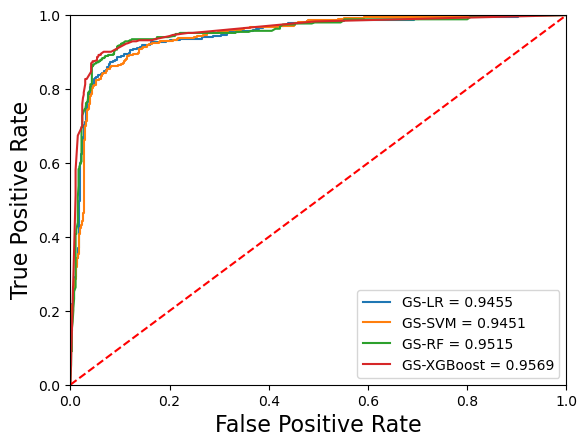

In [376]:
plt.plot(fpr1_3, tpr1_3, label = 'GS-LR = %0.4f' % auc1_3)
plt.plot(fpr2_3, tpr2_3, label = 'GS-SVM = %0.4f' % auc2_3)
plt.plot(fpr3_3, tpr3_3, label = 'GS-RF = %0.4f' % auc3_3)
plt.plot(fpr4_3, tpr4_3, label = 'GS-XGBoost = %0.4f' % auc4_3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.savefig('picture/ROC_GS.jpg', dpi = 300, facecolor = 'w')
plt.show()

# Confusion matrix

In [377]:
class_names = ['0', '1']

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                         model=''):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.subplots_adjust(left = -0.5)
    plt.savefig(f'picture/Confusion_matrix_{model}.jpg', dpi = 300, facecolor = 'w')

Confusion matrix, without normalization


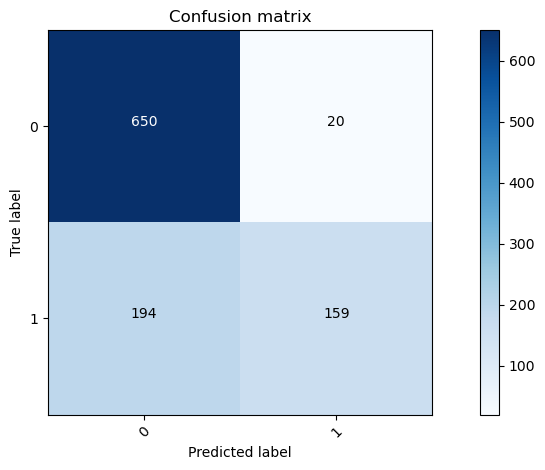

In [378]:
cnf_matrix = confusion_matrix(y_test, predict_LR_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'LR')

Confusion matrix, without normalization


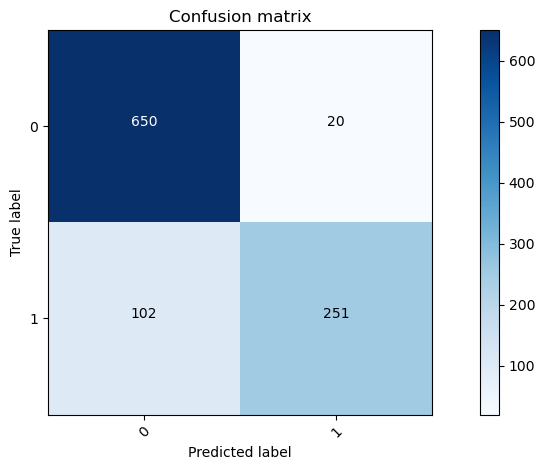

In [379]:
cnf_matrix = confusion_matrix(y_test, predict_LR_GA_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'LR_GA')

Confusion matrix, without normalization


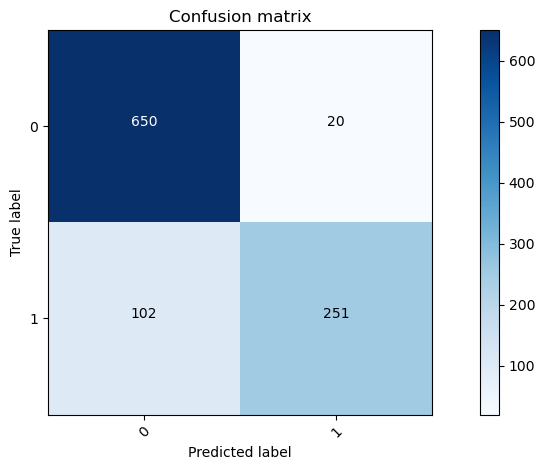

In [380]:
cnf_matrix = confusion_matrix(y_test, predict_LR_GS_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'LR_GS')

Confusion matrix, without normalization


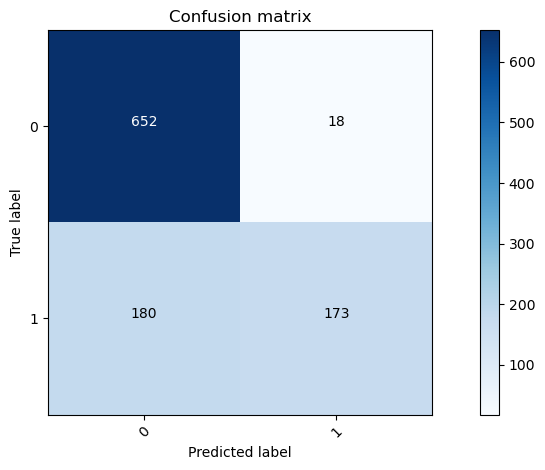

In [381]:
cnf_matrix = confusion_matrix(y_test, predict_SVC_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'SVC')

Confusion matrix, without normalization


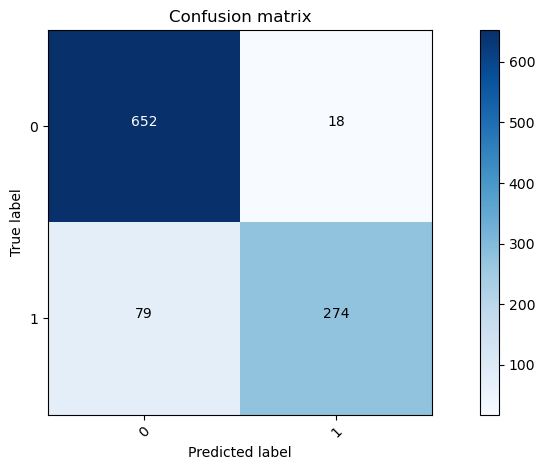

In [382]:
cnf_matrix = confusion_matrix(y_test, predict_SVC_GA_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'SVC_GA')

Confusion matrix, without normalization


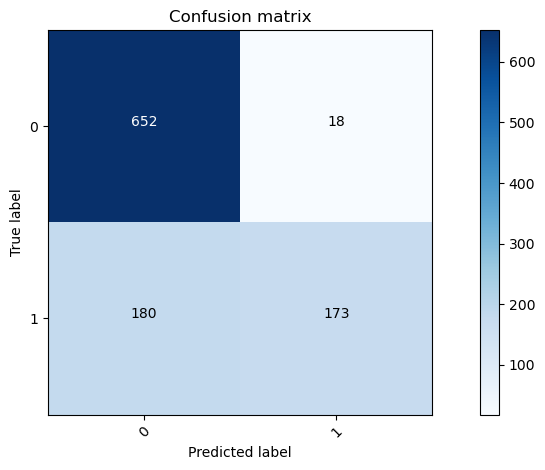

In [383]:
cnf_matrix = confusion_matrix(y_test, predict_SVC_GS_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'SVC_GS')

Confusion matrix, without normalization


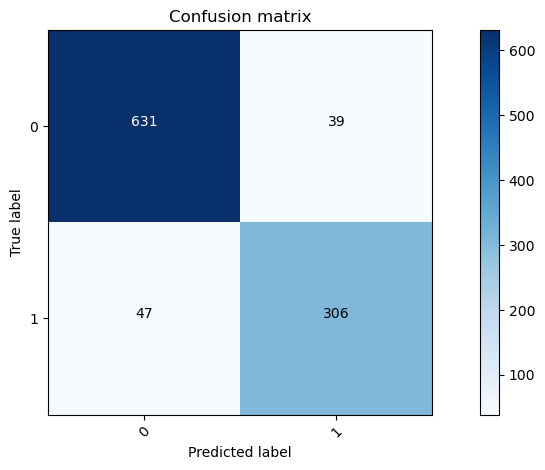

In [384]:
cnf_matrix = confusion_matrix(y_test, predict_RF_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'RF')

Confusion matrix, without normalization


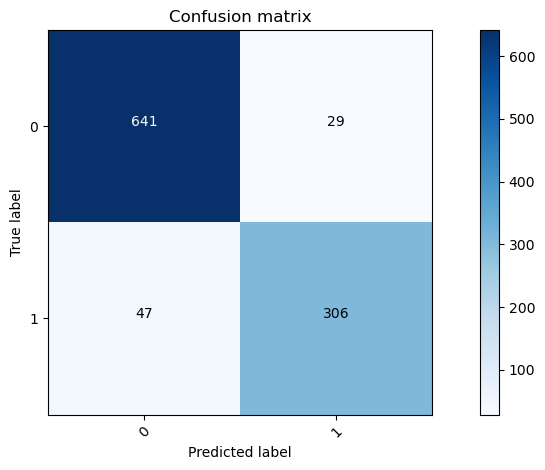

In [385]:
cnf_matrix = confusion_matrix(y_test, predict_RF_GA_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'RF_GA')

Confusion matrix, without normalization


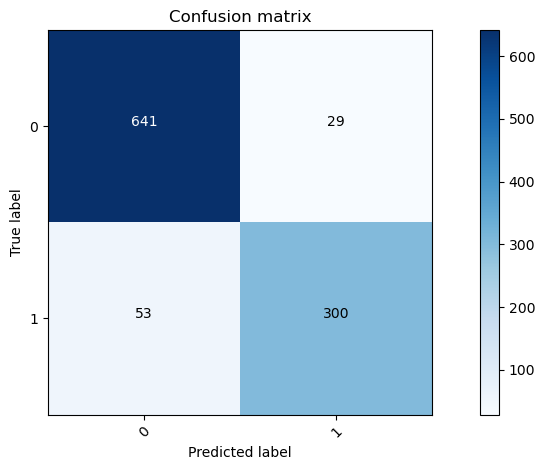

In [386]:
cnf_matrix = confusion_matrix(y_test, predict_RF_GS_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'RF_GS')

Confusion matrix, without normalization


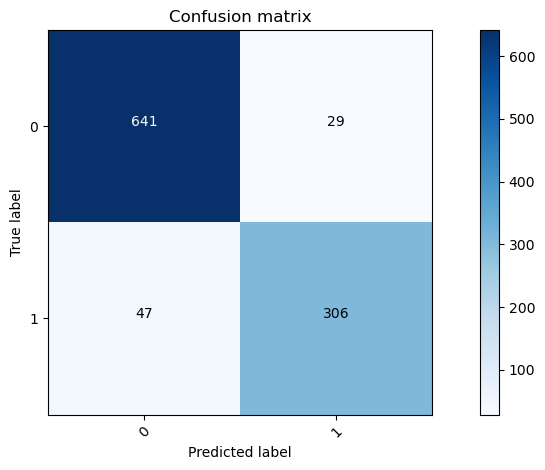

In [387]:
cnf_matrix = confusion_matrix(y_test, predict_XGB_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'XGB')

Confusion matrix, without normalization


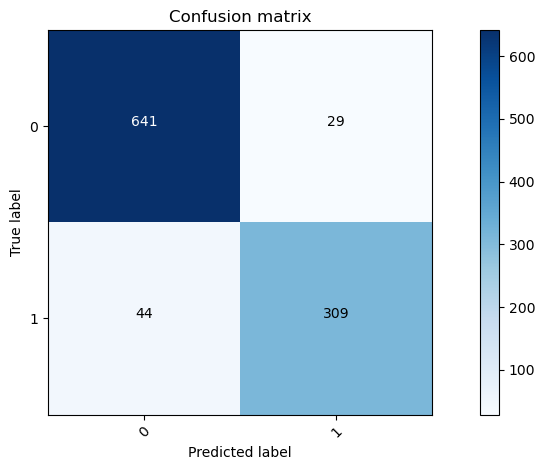

In [388]:
cnf_matrix = confusion_matrix(y_test, predict_XGB_GA_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'XGB_GA')

Confusion matrix, without normalization


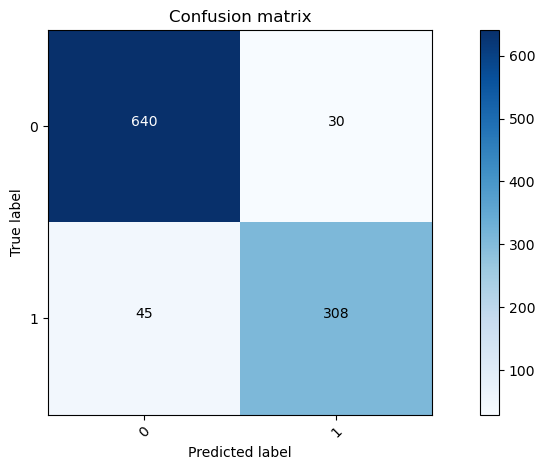

In [389]:
cnf_matrix = confusion_matrix(y_test, predict_XGB_GS_test)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix', model = 'XGB_GS')

In [390]:
for i in ['LR', 'SVC', 'RF', 'XGB']:
    print(f'----------------------------------{i}----------------------------------')
    print('----------------------------------TrianSet----------------------------------')
    cm = confusion_matrix(y_train, eval(f'predict_{i}_train'))
    TN, FP, FN, TP = cm.ravel()
    print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
    print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))
    print('--------------------------------------------------------')
    cm = confusion_matrix(y_train, eval(f'predict_{i}_GA_train'))
    TN, FP, FN, TP = cm.ravel()
    print('TN：', TN, '\nFP：', FP, '\nFN）：', FN, '\nTP：', TP)
    print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))
    print('--------------------------------------------------------')
    cm = confusion_matrix(y_train, eval(f'predict_{i}_GS_train'))
    TN, FP, FN, TP = cm.ravel()
    print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
    print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))
    print('----------------------------------TestSet----------------------------------')
    cm = confusion_matrix(y_test, eval(f'predict_{i}_test'))
    TN, FP, FN, TP = cm.ravel()
    print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
    print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))
    print('--------------------------------------------------------')
    cm = confusion_matrix(y_test, eval(f'predict_{i}_GA_test'))
    TN, FP, FN, TP = cm.ravel()
    print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
    print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))
    print('--------------------------------------------------------')
    cm = confusion_matrix(y_test, eval(f'predict_{i}_GS_test'))
    TN, FP, FN, TP = cm.ravel()
    print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
    print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))

----------------------------------LR----------------------------------
----------------------------------TrianSet----------------------------------
TN： 1518 
FP： 32 
FN： 445 
TP： 391
Positive prediction value： 0.9243498817966903 
Negative prediction value： 0.7733061640346408 
sensitivity： 0.4677033492822967 
specificity： 0.9793548387096774
--------------------------------------------------------
TN： 1519 
FP： 31 
FN）： 239 
TP： 597
Positive prediction value： 0.9506369426751592 
Negative prediction value： 0.8640500568828214 
sensitivity： 0.7141148325358851 
specificity： 0.98
--------------------------------------------------------
TN： 1519 
FP： 31 
FN： 236 
TP： 600
Positive prediction value： 0.9508716323296355 
Negative prediction value： 0.8655270655270655 
sensitivity： 0.7177033492822966 
specificity： 0.98
----------------------------------TestSet----------------------------------
TN： 650 
FP： 20 
FN： 194 
TP： 159
Positive prediction value： 0.888268156424581 
Negative prediction value： 

# Shap

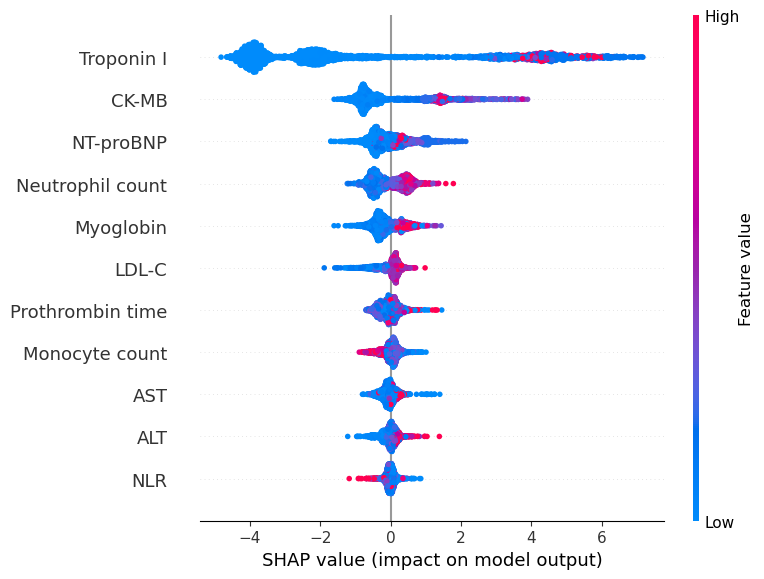

In [391]:
X_train = pd.DataFrame(X_train)
X_train.columns = ['Troponin I', 'CK-MB', 'Myoglobin', 'AST', 'NT-proBNP', 'Neutrophil count', 'ALT', 'NLR', 'Monocyte count', 'Prothrombin time', 'LDL-C']
model_SHAP = shap.TreeExplainer(model_XGB_GA)
shap_values = model_SHAP.shap_values(X_train.values)
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('picture/shap.jpg', dpi = 300, facecolor = 'w', bbox_inches='tight')

# External Validation

In [392]:
dfValidation = pd.read_excel('data/Validation Data.xlsx')
dfV = dfValidation[['Troponin I','CK-MB','Myoglobin','AST','NT-proBNP','Neutrophil count','ALT','NLR','Monocyte count','Prothrombin time','LDL-C']]
dfV = model_M.transform(dfV)

In [393]:
predict_XGB_Validation = model_XGB_GA.predict(dfV)
print(classification_report(dfValidation['AMI'], predict_XGB_Validation))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       247
           1       0.94      0.82      0.87       142

    accuracy                           0.91       389
   macro avg       0.92      0.89      0.90       389
weighted avg       0.91      0.91      0.91       389



In [394]:
print(accuracy_score(dfValidation['AMI'], predict_XGB_Validation))

0.9125964010282777


In [395]:
predict_RF_Validation = model_RF_GA.predict(dfV)
print(classification_report(dfValidation['AMI'], predict_RF_Validation))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       247
           1       0.81      0.83      0.82       142

    accuracy                           0.87       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.87      0.87      0.87       389



In [396]:
print(accuracy_score(dfValidation['AMI'], predict_RF_Validation))

0.8688946015424165


In [397]:
predict_SVC_Validation = model_SVC_GA.predict(dfV)
print(classification_report(dfValidation['AMI'], predict_SVC_Validation))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       247
           1       0.73      0.73      0.73       142

    accuracy                           0.80       389
   macro avg       0.79      0.79      0.79       389
weighted avg       0.80      0.80      0.80       389



In [398]:
print(accuracy_score(dfValidation['AMI'], predict_SVC_Validation))

0.8020565552699229


In [399]:
predict_LR_Validation = model_LR_GA.predict(dfV)
print(classification_report(dfValidation['AMI'], predict_LR_Validation))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       247
           1       0.77      0.72      0.74       142

    accuracy                           0.82       389
   macro avg       0.81      0.80      0.80       389
weighted avg       0.82      0.82      0.82       389



In [400]:
print(accuracy_score(dfValidation['AMI'], predict_LR_Validation))

0.8174807197943444


In [401]:
P1 = model_XGB_GA.predict_proba(dfV)
P2 = model_RF_GA.predict_proba(dfV)
P3 = model_SVC_GA.predict_proba(dfV)
P4 = model_LR_GA.predict_proba(dfV)

In [402]:
fpr1, tpr1, thres1 = roc_curve(dfValidation['AMI'], P1[:, 1])
fpr2, tpr2, thres2 = roc_curve(dfValidation['AMI'], P2[:, 1])
fpr3, tpr3, thres3 = roc_curve(dfValidation['AMI'], P3[:, 1])
fpr4, tpr4, thres4 = roc_curve(dfValidation['AMI'], P4[:, 1])

In [403]:
auc1 = roc_auc_score(dfValidation['AMI'], P1[:, 1])
auc2 = roc_auc_score(dfValidation['AMI'], P2[:, 1])
auc3 = roc_auc_score(dfValidation['AMI'], P3[:, 1])
auc4 = roc_auc_score(dfValidation['AMI'], P4[:, 1])

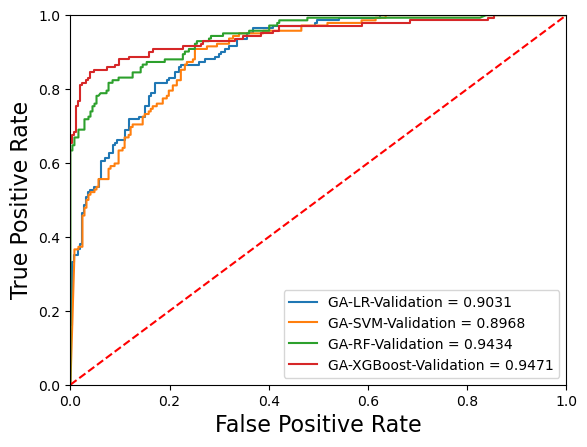

In [404]:
plt.plot(fpr4, tpr4, label = 'GA-LR-Validation = %0.4f' % auc4)
plt.plot(fpr3, tpr3, label = 'GA-SVM-Validation = %0.4f' % auc3)
plt.plot(fpr2, tpr2, label = 'GA-RF-Validation = %0.4f' % auc2)
plt.plot(fpr1, tpr1, label = 'GA-XGBoost-Validation = %0.4f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.savefig('picture/validationDataROC.jpg', dpi = 300, facecolor = 'w')
plt.show()

In [405]:
class_names = ['0', '1']

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                         model=''):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'picture/{model}.jpg', dpi = 300, facecolor = 'w')

Confusion matrix, without normalization


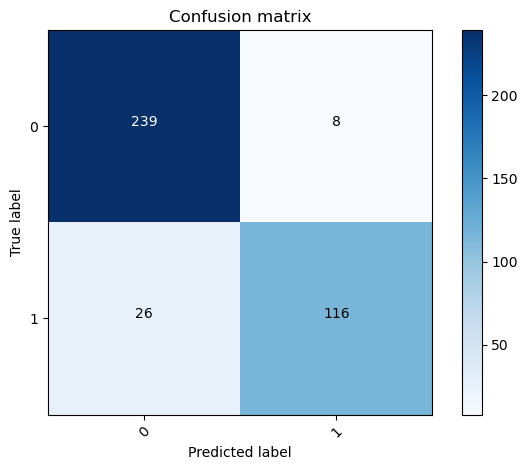

In [406]:
cnf_matrix_XGB = confusion_matrix(dfValidation['AMI'], predict_XGB_Validation)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix_XGB, classes = class_names, title = 'Confusion matrix', model = 'XGBValidationDataConfusionMatrix')

Confusion matrix, without normalization


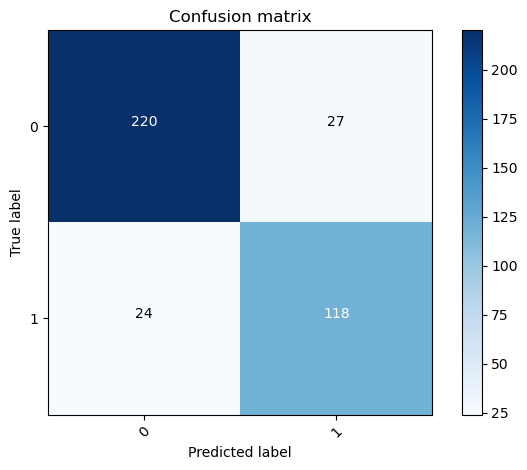

In [407]:
cnf_matrix_RF = confusion_matrix(dfValidation['AMI'], predict_RF_Validation)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix_RF, classes = class_names, title = 'Confusion matrix', model = 'RFValidationDataConfusionMatrix')

Confusion matrix, without normalization


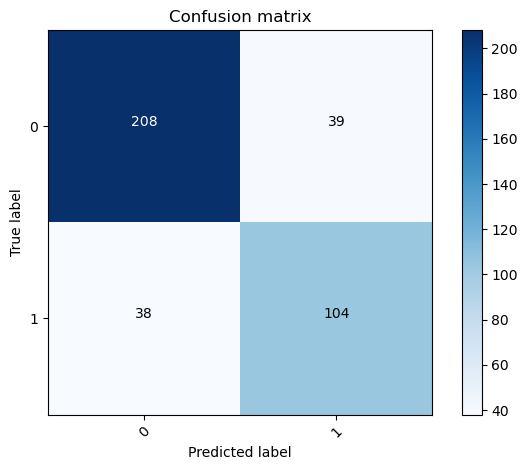

In [408]:
cnf_matrix_SVC = confusion_matrix(dfValidation['AMI'], predict_SVC_Validation)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix_SVC, classes = class_names, title = 'Confusion matrix', model = 'SVCValidationDataConfusionMatrix')

Confusion matrix, without normalization


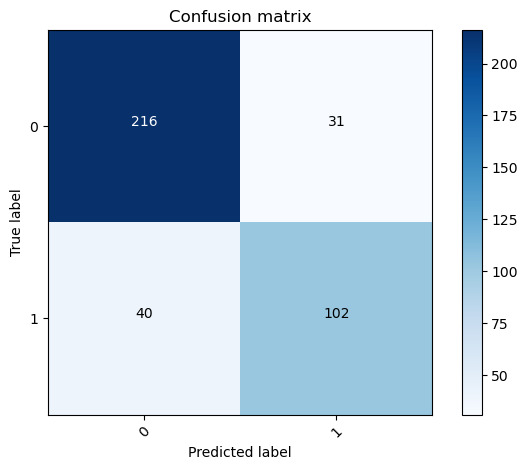

In [409]:
cnf_matrix_LR = confusion_matrix(dfValidation['AMI'], predict_LR_Validation)
np.set_printoptions(precision = 2)
plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes = class_names, title = 'Confusion matrix', model = 'LRValidationDataConfusionMatrix')

In [410]:
TN, FP, FN, TP = cnf_matrix_XGB.ravel()
print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))

TN： 239 
FP： 8 
FN： 26 
TP： 116
Positive prediction value： 0.9354838709677419 
Negative prediction value： 0.9018867924528302 
sensitivity： 0.8169014084507042 
specificity： 0.9676113360323887


In [411]:
TN, FP, FN, TP = cnf_matrix_RF.ravel()
print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))

TN： 220 
FP： 27 
FN： 24 
TP： 118
Positive prediction value： 0.8137931034482758 
Negative prediction value： 0.9016393442622951 
sensitivity： 0.8309859154929577 
specificity： 0.8906882591093117


In [412]:
TN, FP, FN, TP = cnf_matrix_SVC.ravel()
print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))

TN： 208 
FP： 39 
FN： 38 
TP： 104
Positive prediction value： 0.7272727272727273 
Negative prediction value： 0.8455284552845529 
sensitivity： 0.7323943661971831 
specificity： 0.8421052631578947


In [413]:
TN, FP, FN, TP = cnf_matrix_LR.ravel()
print('TN：', TN, '\nFP：', FP, '\nFN：', FN, '\nTP：', TP)
print('Positive prediction value：', TP / (TP + FP), '\nNegative prediction value：', TN / (TN + FN), '\nsensitivity：', TP / (TP + FN), '\nspecificity：', TN / (TN + FP))

TN： 216 
FP： 31 
FN： 40 
TP： 102
Positive prediction value： 0.7669172932330827 
Negative prediction value： 0.84375 
sensitivity： 0.7183098591549296 
specificity： 0.8744939271255061
